This notebook, which contains my visualization toolkit, is a work in progress and I would be happy to hear any suggestions that you might have.  These functions are re-implemented for use outside this notebook in `bmb/source/analysis/visualizations.py`, with changes for handling different input formats, etc.

# Categorical Association

The input for this function is _dual-classified data_.  Film-related examples include $(Actor, Genre)$; $(Decade, Horror Subgenre)$, and $(Genre\,1, Genre\,2)$ for visualizing genre association.

One important property to note is that these categories may not be mutually exclusive.  For example, a single film will generate many $(Actor, Genre)$ pairs, so the total number of films with genre $g$ cannot be found by simply counting the cateogy-vectors where $Genre = g$.
This property is contrary to the assumptions of many statistical tests, which limits our options for analysis; for example the $\chi^2$ Test cannot be used, although the $\chi^2$ Statistic may be calculated as part of the $\phi$ Coefficient.

## Visualization Description

The `visualize_categorical_association` function will use input `data` consisting of $(Category\,1, Category\,2)$ pairs to create three heatmaps:
1. The first heatmap is a count of the values in the input data.
2. The second heatmap shows the values that would be expected if $Category\,1$ and $Category\,2$ were independent.
3. The third heatmap is the relative error between the values in the first and second heatmaps.

## Implementation

In [1]:
from matplotlib  import pyplot as plt
from collections import defaultdict
from bmb.source.cross_classification import heatmap
import math
import seaborn as sns

In [25]:
def _dictionary_to_2d_array( data, col_order, row_order):
    # data has format dd[col][row] = value
    return [[ data[ col][ row]
        for row in row_order ]
        for col in col_order ]

def visualize_categorical_association( 
    data, 
    total_count,
    category_1_count,
    category_2_count,
    category_1_order, 
    category_2_order,
    title="Count of Input Data",
    figsize=(6, 6)):
    
    figsize = (0.75 * len(category_2_order), 0.5 * len(category_1_order))
    
    actual = defaultdict( lambda: defaultdict( lambda: 0))
    for cat1, cat2 in data:
        actual[ cat1][ cat2]    += 1


    expected = { a: {b:
                     category_1_count[a] * category_2_count[b] / total_count
                for b in category_2_order} for a in category_1_order}
       
    absolute_error = { a: {b:
                     actual[a][b] - expected[a][b]
                for b in category_2_order} for a in category_1_order}
 
    relative_error = { a: {b:
                 absolute_error[a][b] / expected[a][b]
                for b in category_2_order} for a in category_1_order}
    
    plt.figure(figsize=figsize)
    plt.title( title)
    sns.heatmap(
        _dictionary_to_2d_array( actual, category_1_order, category_2_order),
        cmap="Blues",
        yticklabels = category_1_order, 
        xticklabels = category_2_order,
        annot=True,
        fmt="d"
    )

    plt.figure(figsize=figsize)
    plt.title( "Count Expected for Independent Categories")
    sns.heatmap(
        _dictionary_to_2d_array( expected, category_1_order, category_2_order),
        cmap="Blues",
        yticklabels = category_1_order, 
        xticklabels = category_2_order,
        annot=True,
        fmt=".0f"
    )
    
    plt.figure(figsize=figsize)
    plt.title( "Percent Difference from Independent")
    sns.heatmap(
        _dictionary_to_2d_array( relative_error, category_1_order, category_2_order),
        cmap="RdYlGn",
        yticklabels = category_1_order, 
        xticklabels = category_2_order,
        annot=True,
        fmt=".0%",
        center=0,
        vmin=-1,
        vmax=1
    )

## Example

### Building the Example Dataset

In [3]:
from bmb import ProcessingDB
from bmb.source.cross_classification import category_pairs
from tqdm.notebook import tqdm
import random

In [28]:
# Identifying 1930-2019 films.
db       = ProcessingDB()
film_ids = db.get( 'SELECT id FROM Film WHERE year > 1930')


# Find the films' genre combinations
genre_combinations = dict()
GENRES_FOR_FILM_ID = """
    SELECT Genre.text 
    FROM FilmGenre JOIN Genre ON FilmGenre.Genre=Genre.id 
    WHERE FilmGenre.film=?"""
for film_id in tqdm( film_ids):
    genre_combinations[ film_id] = db.get( GENRES_FOR_FILM_ID, film_id )

# Print an example with at least 3 genres.
while True:
    film_id = random.choice( list( genre_combinations.keys()))
    combo   = genre_combinations[ film_id]
    if len( combo) >= 3:
        title, year = db.select_one( 'title', 'year', 'Film', id=film_id )
        print( f"As an example, {title} ({year}) has genres ({', '.join( combo)})")
        break

  0%|          | 0/11355 [00:00<?, ?it/s]

As an example, Man About Town (2006) has genres (Comedy, Drama, Romance)


In [29]:
# Create the cross classification AKA the list of genre coincidence pairs:
num_films   = len( genre_combinations)
genre_pairs = list()
genre_count = defaultdict( lambda: 0)
year_count  = defaultdict( lambda: 0)
decade_count = defaultdict( lambda: 0)

year_genres = list()
for film_id, genre_combination in tqdm(genre_combinations.items()):
    genre_pairs += category_pairs( genre_combination, reflexive=True)
    
    year = db.select_one( 'year', 'Film', id=film_id)
    year_count[ year] += 1
    
    decade = f"{(year // 10) * 10}'s"
    decade_count[ decade] += 1
    
    for genre in genre_combination:
        genre_count[ genre] += 1
        year_genres.append(( f"{(year // 10) * 10}'s", genre))


  0%|          | 0/11355 [00:00<?, ?it/s]

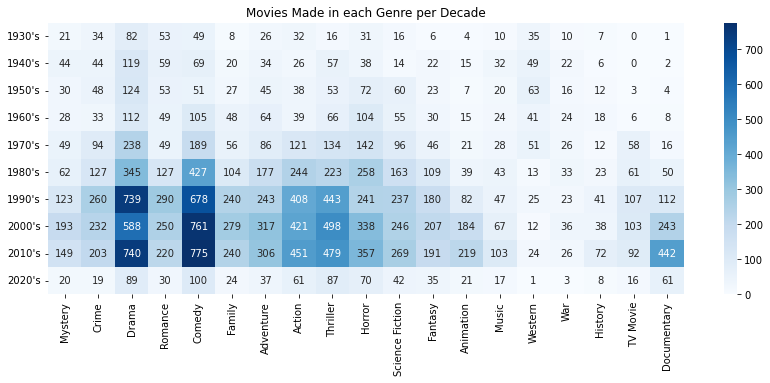

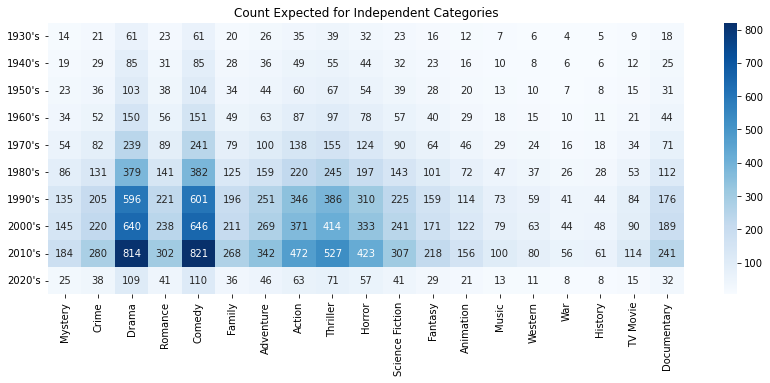

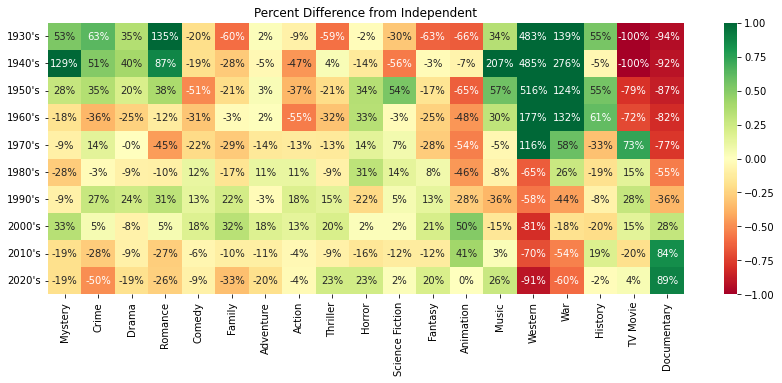

In [30]:
visualize_categorical_association(
    year_genres,
    num_films,
    decade_count,
    genre_count,
    sorted(set((t[0] for t in year_genres))),
    db.genre_order(),#[ g for g in db.genre_order() if g not in ("Documentary", "TV Movie", "Western", "War")],#
    title="Movies Made in each Genre per Decade"
)